# PROTOTYPE 2: static and free vibration analysis for 2D frame structures - 2d beam element (3 dofs) 



The initial development of the library began with this Jupyter Notebook. The idea was to facilitate interactive experimentation and visualization. 
This preliminary notebook-driven  development was ideal for:
- Rapid prototyping of element formulations (e.g., Euler-Bernoulli beam elements)
- Testing stiffness matrix assembly procedures
- Visualizing mode shapes and validating results
- Debugging in a modular and incremental way

After validating the methodology in the notebook environment, the code has been refactored into reusable and well-defined functions.

Once core functions were tested independently, they were structured into a Python package **fem_toolbox**


The idea here is trying to write down more general functions with respect to the first exploratory prototype, in order to use them in a later stage to build up the library

**At least for the moment, buckling and stress stiffening phenomenas due to combined axial and trasversal loads are ignored**

Just to remember why we don't use rod elements:
"Truss joints are of the pin joint variety, allowing the members to rotate freely around the pin. Truss cannot therefore transfer moments. Only axial forces are applied to members. On the other hand, the members of frames are rigidly joined at joints using bolting and welding"



### Imports

In [85]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
# using sympy only for printing
import sympy as sy

### Element stiffness matrix

Note that you can build the stiffness matrix for the 3dofs beam by combining k_rod and k_beam. Maybe it s faster to just hard code it, also because otherwise the function should make other 2 function calls for building up k for every element

In [86]:
# using notation "local" since now it is also necessary to rotate the matrix in the global ref system before assemblying

def k_rod(E, A, L):
    """2-node rod element stiffness matrix"""
    k_local = (E*A/L) * np.array([[1, -1], 
                            [-1, 1]])
    return k_local

def k_beam(E, I, L):
    """2-node beam element stiffness matrix (Euler Bernoulli beam)"""
    k_local = (E*I/L**3) * np.array([[12, 6*L, -12, 6*L],
                             [6*L, 4*L**2, -6*L, 2*L**2],
                             [-12, -6*L, 12, -6*L],
                             [6*L, 2*L**2, -6*L, 4*L**2]]) 
    return k_local

def k_beam2d(E, A, I, L):
    """
    Local stiffness matrix (6x6) for a 2D beam (plane frame) element.
    Includes axial and bending contributions.
    
    DOFs: [u1, v1, θ1, u2, v2, θ2]  (2 nodes × 3 DOFs each)
    
    Parameters:
        E : float  - Young's modulus
        A : float  - Cross-sectional area
        I : float  - Moment of inertia
        L : float  - Length of the element
    
    Returns:
        K_local : (6x6) np.ndarray - Local stiffness matrix
    """
    # Axial stiffness component (rod behavior)
    k_axial = (E * A / L) * np.array([
        [ 1,  0,  0, -1,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [-1,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]
    ])

    # Bending stiffness component (Euler–Bernoulli beam behavior)
    coeff = E * I / L**3
    k_bending = coeff * np.array([
        [ 0,     0,      0,      0,     0,      0     ],
        [ 0,    12,     6*L,     0,   -12,     6*L    ],
        [ 0,   6*L,   4*L**2,    0,  -6*L,   2*L**2   ],
        [ 0,     0,      0,      0,     0,      0     ],
        [ 0,   -12,   -6*L,      0,    12,   -6*L     ],
        [ 0,   6*L,   2*L**2,    0,  -6*L,   4*L**2   ]
    ])

    # Total local stiffness matrix
    k_local = k_axial + k_bending

    return k_local

### Element mass matrix (consistent matrices, not lumped)

In [87]:
# using notation "local" since now it is also necessary to rotate the matrix in the global ref system before assemblying

def m_rod(rho, A, L):
    """Consistent mass matrix for bar element"""
    m_local = rho * A * L / 6 * np.array([
        [2, 1],
        [1, 2]
    ])
    return m_local


def m_beam(rho, A, L):
    """Consistent mass matrix for 2-node Euler-Bernoulli beam element"""
    m_local = rho * A * L / 420 * np.array([
        [156, 22*L, 54, -13*L],
        [22*L, 4*L**2, 13*L, -3*L**2],
        [54, 13*L, 156, -22*L],
        [-13*L, -3*L**2, -22*L, 4*L**2]
    ])
    return m_local


def m_beam2d(rho, A, L):
    """
    Local consistent mass matrix (6x6) for a 2D beam (plane frame) element.
    Includes both axial and bending contributions.
    
    DOFs: [u1, v1, θ1, u2, v2, θ2]

    Parameters:
        rho : float  - Material density (kg/mm³)
        A   : float  - Cross-sectional area (mm²)
        L   : float  - Length of the element (mm)

    Returns:
        M_local : (6x6) np.ndarray - Local mass matrix
    """

    m = rho * A * L  # total mass of element

    # Axial (rod) mass terms — 2x2 consistent mass matrix for u DOFs
    m_axial = (m / 6) * np.array([
        [2, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 2, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ])

    # Bending mass matrix from Euler–Bernoulli theory (for v and theta)
    coeff = rho * A * L / 420
    m_bending = coeff * np.array([
        [0,    0,     0,    0,    0,     0],
        [0,   156,   22*L,   0,   54,   -13*L],
        [0,  22*L,  4*L**2,  0, 13*L,  -3*L**2],
        [0,    0,     0,    0,    0,     0],
        [0,    54,   13*L,   0,  156,  -22*L],
        [0, -13*L, -3*L**2,  0, -22*L, 4*L**2]
    ])

    # Total local mass matrix
    m_local = m_axial + m_bending

    return m_local


### Rotation matrix

We have rotation around the z axis. This needs to be done for both the nodes of the element independently.
Note that the translation u and v is subjected to rotation, but theta should stay the same since it is rotation around z axis

In [88]:
def rotation_2d(x1, y1, x2, y2):
    """
    Returns the 6x6 rotation matrix for a 2D beam element
    between points (x1, y1) and (x2, y2).

    Parameters:
        x1, y1: coordinates of the first node
        x2, y2: coordinates of the second node

    Returns:
        T: (6x6) np.ndarray - Rotation matrix
    """
    # Direction cosines
    dx = x2 - x1
    dy = y2 - y1
    L = np.sqrt(dx**2 + dy**2)

    if L == 0:
        raise ValueError("Element length is zero. Check node coordinates.")

    c = dx / L
    s = dy / L

    # Rotation matrix R 
    R = np.zeros((6, 6))    # every node has 3 dofs

    # Fill sub-blocks
    R_local = np.array([
        [c, s, 0],
        [-s, c, 0],
        [0, 0, 1]
    ])

    # Upper-left 3x3
    R[0:3, 0:3] = R_local
    # Lower-right 3x3
    R[3:6, 3:6] = R_local


    return R

In [89]:
RRR = rotation_2d(0, 0, -5, -5)
display(sy.Matrix(RRR))
display(sy.Matrix(RRR.T))

Matrix([
[-0.707106781186547, -0.707106781186547,   0,                  0,                  0,   0],
[ 0.707106781186547, -0.707106781186547,   0,                  0,                  0,   0],
[                 0,                  0, 1.0,                  0,                  0,   0],
[                 0,                  0,   0, -0.707106781186547, -0.707106781186547,   0],
[                 0,                  0,   0,  0.707106781186547, -0.707106781186547,   0],
[                 0,                  0,   0,                  0,                  0, 1.0]])

Matrix([
[-0.707106781186547,  0.707106781186547,   0,                  0,                  0,   0],
[-0.707106781186547, -0.707106781186547,   0,                  0,                  0,   0],
[                 0,                  0, 1.0,                  0,                  0,   0],
[                 0,                  0,   0, -0.707106781186547,  0.707106781186547,   0],
[                 0,                  0,   0, -0.707106781186547, -0.707106781186547,   0],
[                 0,                  0,   0,                  0,                  0, 1.0]])

In [90]:
Rtt = RRR @ RRR.T
display(sy.Matrix(Rtt))
np.allclose(RRR.T @ RRR, np.eye(6))

Matrix([
[                 1.0, 2.23711431707574e-17,   0,                    0,                    0,   0],
[2.23711431707574e-17,                  1.0,   0,                    0,                    0,   0],
[                   0,                    0, 1.0,                    0,                    0,   0],
[                   0,                    0,   0,                  1.0, 2.23711431707574e-17,   0],
[                   0,                    0,   0, 2.23711431707574e-17,                  1.0,   0],
[                   0,                    0,   0,                    0,                    0, 1.0]])

True

### Geometry definition: input file 

2 things are necessary:
1. the coordinates of the end points of each beam of the structure
2. the connectivity relations between points and beams (do we have a beam between points p3 and p4 or between p3 and p5?)
3. Information related to the cross-section: area and second moment of inertia
4. Material properties E and $\rho$, assuming same material for the entire frame

**Input file format:** material properties padded with four zeros in the first line. Then, explicit connectivity-based input + cross-section parameters, so each line of the file defines one beam element, as two points in 2D space + area and inertia moment: 

 E $\rho$ 0 0 0 0 
 
 x_1 y_1 x_2 y_2 A I

 

This format gives:
- the node coordinates
- the beam connectivity
- the beam cross-section properties
- the material parameters


In [91]:
def read_frame_structure(file_path):
    """
    Reads a frame definition file where each line is:
        x1 y1 x2 y2 A I  (coordinates of beam endpoints and cross-section properties)
    The first line specifies the material properties: E  rho 0 0 0 0

    Returns:
        node_coords_beam : (N, 2) ndarray - unique node coordinates
        connectivity_beam : (E, 2) ndarray - element connectivity as node indices
        beam_crossSections : list fo dicts per beam with A and I
    """
    raw_data = np.loadtxt(file_path, comments='#')
    
    # simple check on 2nd line
    if raw_data.shape[1] != 6:
        raise ValueError("Each line must contain 4 numbers: x1 y1 x2 y2 A I")

    # material properties
    E = raw_data[0,0]
    rho = raw_data[0,1]
    mat_properties = {"E":E, "rho":rho}

    # extracting coordinates
    coords = raw_data[1:, :4]
    cross_sections_params = raw_data[1:, 4:]

    # Collect all endpoints in one vertical vector (multiple are surely present!)
    all_points = np.vstack([coords[:, :2], coords[:, 2:]])

    # Round to avoid floating-point duplicates (if you generate points with software)
    all_points = np.round(all_points, decimals=5)

    # Cut away the repeated points
    node_coords_beam, _ = np.unique(all_points, axis=0, return_inverse=True)

    # Build connectivity_beam (using the INDEXES of the points)
    num_beams = coords.shape[0]
    connectivity_beam = np.zeros((num_beams, 2), dtype=int)
    
    # array for collecting info on cross section for each beam
    beam_crossSections = []

    for i in range(num_beams):
        p1 = coords[i, :2]
        p2 = coords[i, 2:]
        
        # finding the index related with the specific point
        idx1 = np.where((node_coords_beam == np.round(p1, 5)).all(axis=1))[0][0]
        idx2 = np.where((node_coords_beam == np.round(p2, 5)).all(axis=1))[0][0]

        connectivity_beam[i] = [idx1, idx2]
        beam_crossSections.append({
            "A": cross_sections_params[i, 0],
            "I": cross_sections_params[i, 1]
        })


    return node_coords_beam, connectivity_beam, beam_crossSections, mat_properties

In [92]:
nodes_coords_beam, beam_connectivity, beam_crossSections, mat_properties = read_frame_structure("../Tutorials/geometry&boundary-files/myframe.txt")

# Check
display(sy.Matrix(nodes_coords_beam), sy.Matrix(beam_connectivity), sy.Matrix(beam_crossSections)) # trying to create a sympy.Matrix from data that includes non-symbolic (non-Expr) type is deprecated. Still this is the easiest way to get good-looking formatting

/tmp/ipykernel_116833/1404845245.py:4: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  display(sy.Matrix(nodes_coords_beam), sy.Matrix(beam_connectivity), sy.Matrix(beam_crossSections)) # trying to create a sympy.Matrix from data that includes non-symbolic (non-Expr) type is deprecated. Still this is the easiest way to get good-looking formatting


Matrix([
[     0,      0],
[     0, 1000.0],
[2000.0, 1000.0],
[3000.0,      0]])

Matrix([
[0, 3],
[2, 3],
[1, 2]])

Matrix([
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}]])

### Finite elements definition: beams discretization

Right now, we have:
- a list of node coordinates
- a connectivity matrix that defines the beams, using the indexes of the nodes
- a list that associates the cross-section parameters with each beam
- a list contatining the material properties

But each beam needs to be discretized into multiple FE elements. Every element needs to inheritthe cross-section properties from its parent beam 

In [93]:
def discretize_beams(node_coords_beam, beam_connectivity, beam_crossSections, elements_per_beam=5, strategy="uniform"):
    """
    Discretizes beams into FEM elements, keeping A and I per element.
    
    Returns:
        fem_nodes : (N, 2) ndarray
        fem_elements : list of (node_i, node_j)
        element_crossSections : list of dicts with A and I for each element
    """
    fem_nodes = []
    node_index_map = {}  # maps (x,y) to node index ((x, y) = key, index = value)
    fem_elements = []
    element_crossSections = []

    # avoid adding duplicates to the node list, and ensures to get consistent indexing
    current_index = 0
    def get_or_add_node(x, y):
        nonlocal current_index
        key = (round(x, 5), round(y, 5))
        if key not in node_index_map:
            node_index_map[key] = current_index
            fem_nodes.append([x, y])
            current_index += 1
        return node_index_map[key]

    
    for beam_idx, (n1, n2) in enumerate(beam_connectivity):
        p1 = node_coords_beam[n1]
        p2 = node_coords_beam[n2]

        A = beam_crossSections[beam_idx]["A"]
        I = beam_crossSections[beam_idx]["I"]


        # uniform subdivision of the beam into elements
        for i in range(elements_per_beam):
            # t1,2: parametric values, "how far we are along the beam"
            t1 = i / elements_per_beam
            t2 = (i + 1) / elements_per_beam

            # linear interpolation along the element
            x1, y1 = (1 - t1) * p1 + t1 * p2
            x2, y2 = (1 - t2) * p1 + t2 * p2

            idx1 = get_or_add_node(x1, y1)
            idx2 = get_or_add_node(x2, y2)

            fem_elements.append([idx1, idx2])
            element_crossSections.append({"A": A, "I": I})

    return np.array(fem_nodes), np.array(fem_elements), element_crossSections 


In [94]:
fem_nodes, fem_elements, element_crossSections = discretize_beams(nodes_coords_beam, beam_connectivity, beam_crossSections, elements_per_beam=5)

# Check
display(sy.Matrix(fem_nodes), sy.Matrix(fem_elements), sy.Matrix(element_crossSections) )

/tmp/ipykernel_116833/831992908.py:4: SymPyDeprecationWarning: 

non-Expr objects in a Matrix is deprecated. Matrix represents
a mathematical matrix. To represent a container of non-numeric
entities, Use a list of lists, TableForm, NumPy array, or some
other data structure instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-non-expr-in-matrix
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  display(sy.Matrix(fem_nodes), sy.Matrix(fem_elements), sy.Matrix(element_crossSections) )


Matrix([
[     0,      0],
[ 600.0,      0],
[1200.0,      0],
[1800.0,      0],
[2400.0,      0],
[3000.0,      0],
[2000.0, 1000.0],
[2200.0,  800.0],
[2400.0,  600.0],
[2600.0,  400.0],
[2800.0,  200.0],
[     0, 1000.0],
[ 400.0, 1000.0],
[ 800.0, 1000.0],
[1200.0, 1000.0],
[1600.0, 1000.0]])

Matrix([
[ 0,  1],
[ 1,  2],
[ 2,  3],
[ 3,  4],
[ 4,  5],
[ 6,  7],
[ 7,  8],
[ 8,  9],
[ 9, 10],
[10,  5],
[11, 12],
[12, 13],
[13, 14],
[14, 15],
[15,  6]])

Matrix([
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}],
[{I: 39900.0, A: 324.0}]])

### Geometry and discretization visualization for visual feedback

In [95]:
import matplotlib.pyplot as plt

def plot_discretized_frame(original_nodes, original_beams, fem_nodes, fem_elements, show_elements=True, show_nodes=True, node_label_offset=0.02):
    """
    Visualizes the original beam geometry and the discretized FEM mesh.

    Parameters:
        original_nodes : (N, 2) array of unique input nodes
        original_beams : (B, 2) array of beam connectivity (node indices)
        fem_nodes : (M, 2) array of discretized FEM nodes
        fem_elements : (E, 2) array of FEM element connectivity
        show_elements : bool - whether to show element numbers
        show_nodes : bool - whether to show node numbers
        node_label_offset : float - visual offset for node label
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot original geometry (beam lines)
    for start, end in original_beams:
        x_vals = [original_nodes[start][0], original_nodes[end][0]]
        y_vals = [original_nodes[start][1], original_nodes[end][1]]
        ax.plot(x_vals, y_vals, 'k--', linewidth=1, alpha=0.3)

    # Plot discretized FEM elements
    for i, (n1, n2) in enumerate(fem_elements):
        x_vals = [fem_nodes[n1][0], fem_nodes[n2][0]]
        y_vals = [fem_nodes[n1][1], fem_nodes[n2][1]]
        ax.plot(x_vals, y_vals, 'b-', linewidth=2)

        # Optional element ID at midpoint
        if show_elements:
            xm, ym = (np.array(x_vals).mean(), np.array(y_vals).mean())
            ax.text(xm, ym, str(i), color='blue', fontsize=8, ha='center', va='center')

    # Plot and label nodes
    for i, (x, y) in enumerate(fem_nodes):
        ax.plot(x, y, 'ro', markersize=4)
        if show_nodes:
            ax.text(x + node_label_offset, y + node_label_offset, str(i), color='red', fontsize=9)

    ax.set_aspect('equal')
    ax.set_title("Discretized Frame Geometry")
    ax.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


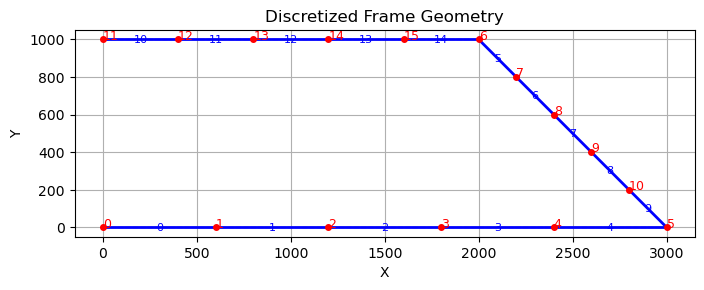

In [96]:
plot_discretized_frame(nodes_coords_beam, beam_connectivity, fem_nodes, fem_elements)

### Assembling the global stiffness matrix

Here is important to remember the transformation of the k matrix from local ref system to global

In [97]:
# understanding the data structures we are working with
display(sy.Matrix(fem_elements), sy.Matrix(fem_nodes))

Matrix([
[ 0,  1],
[ 1,  2],
[ 2,  3],
[ 3,  4],
[ 4,  5],
[ 6,  7],
[ 7,  8],
[ 8,  9],
[ 9, 10],
[10,  5],
[11, 12],
[12, 13],
[13, 14],
[14, 15],
[15,  6]])

Matrix([
[     0,      0],
[ 600.0,      0],
[1200.0,      0],
[1800.0,      0],
[2400.0,      0],
[3000.0,      0],
[2000.0, 1000.0],
[2200.0,  800.0],
[2400.0,  600.0],
[2600.0,  400.0],
[2800.0,  200.0],
[     0, 1000.0],
[ 400.0, 1000.0],
[ 800.0, 1000.0],
[1200.0, 1000.0],
[1600.0, 1000.0]])

In [98]:
def get_dof_map(ndofs_per_node, n1, n2):
    if ndofs_per_node == 1:     # bar element
        # defining the dof mapping 
        dof_map = [n1 * ndofs_per_node, n2 * ndofs_per_node]

    if ndofs_per_node == 2:     # beam element
        dof_map = [
        n1 * ndofs_per_node,     # v_i
        n1 * ndofs_per_node + 1, # θ_i
        n2 * ndofs_per_node,     # v_j
        n2 * ndofs_per_node + 1  # θ_j
    ]
        
    else:       # 2D beam element
        dof_map = [
            ndofs_per_node * n1 + 0,  # u_i
            ndofs_per_node * n1 + 1,  # v_i
            ndofs_per_node * n1 + 2,  # θ_i
            ndofs_per_node * n2 + 0,  # u_j
            ndofs_per_node * n2 + 1,  # v_j
            ndofs_per_node * n2 + 2   # θ_j
        ]

    return dof_map




def assembleK(fem_nodes, fem_elements, element_crossSections, mat_properties):
    """
    Assemble the global stiffness matrix for 2D frame structure.
    
    Arguments:
        fem_nodes : (N, 2) array of node coordinates
        fem_elements : list of (node_i, node_j)
        element_crossSections : list of dicts with 'A' and 'I'
        element_materials : list of dicts with 'E' (and possibly 'rho')
    
    Returns:
        K_global : (ndof, ndof) ndarray, the global stiffness matrix
    """
    ndof_per_node = 3
    total_nodes = fem_nodes.shape[0]
    total_dofs = ndof_per_node * total_nodes

    K_global = np.zeros((total_dofs, total_dofs))

    E = mat_properties['E']

    for e, (i, j) in enumerate(fem_elements):   
        # get start and end point of the fem element
        xi, yi = fem_nodes[i]
        xj, yj = fem_nodes[j]

        # get geometrical properties
        L = np.sqrt((xj - xi)**2 + (yj - yi)**2)
        
        A = element_crossSections[e]['A']
        I = element_crossSections[e]['I']

        # build local stiffness matrix
        k_local = k_beam2d(E, A, I, L)

        # rotation matrix from local to global
        R = rotation_2d(xi, yi, xj, yj)

        # Transform local stiffness to global coordinates
        k_global = R.T @ k_local @ R

        # map element DOFs to global DOFs
        dofs = get_dof_map(ndof_per_node, i, j)

        # assemble into global matrix
        for a in range(ndof_per_node*2):
            for b in range(ndof_per_node*2):
                K_global[dofs[a], dofs[b]] += k_global[a, b]

    return K_global


In [99]:
K_frame = assembleK(fem_nodes, fem_elements, element_crossSections, mat_properties)

### Assemblying the global mass matrix

Procedure is identical, but the mass matrix depends on $\rho$, A and L instead of E,A,I,L as the stiffness matrix

In [100]:
def assembleM_2dbeam(fem_nodes, fem_elements, element_sections, mat_properties):
    """
    Assemble the global mass matrix for 2D frame structure.

    Arguments:
        fem_nodes : (N, 2) array of node coordinates
        fem_elements : list of (node_i, node_j)
        element_sections : list of dicts with 'A' and 'I'
        mat_properties : dict with 'E' and 'rho' (ρ shared across all elements)

    Returns:
        M_global : (ndof, ndof) ndarray, the global mass matrix
    """
    ndof_per_node = 3
    total_nodes = fem_nodes.shape[0]
    total_dofs = ndof_per_node * total_nodes

    M_global = np.zeros((total_dofs, total_dofs))

    # Extract density 
    rho = mat_properties['rho']

    for e, (i, j) in enumerate(fem_elements):
        xi, yi = fem_nodes[i]
        xj, yj = fem_nodes[j]

        L = np.sqrt((xj - xi)**2 + (yj - yi)**2)
        A = element_sections[e]['A']

        # local mass matrix (consistent mass)
        m_local = m_beam2d(rho, A, L)

        # rotation matrix for transforming to global coords
        R = rotation_2d(xi, yi, xj, yj)

        # global mass matrix for element
        m_global = R.T @ m_local @ R

        # DOF mapping
        dofs = get_dof_map(ndof_per_node, i, j)

        # assembly
        for a in range(ndof_per_node*2):
            for b in range(ndof_per_node*2):
                M_global[dofs[a], dofs[b]] += m_global[a, b]

    return M_global


In [101]:
M_frame = assembleM_2dbeam(fem_nodes, fem_elements, element_crossSections, mat_properties)

### Reading BC and loads from file

Format for input file:

BC node (dof value) (dof value) ...

FORCE node dof value

1. BC 0 (0 0.0) (1 0.0) (2 0.0)        
2. BC 3 (1 0.0)            
3. FORCE 4 1 -1000         
4. FORCE 5 2 50            

would be:

1. Fully fixed node 0
2. Node 3 fixed in v only
3. Vertical force at node 4
4. Moment at node 5



In [102]:
import re   # for parsing, regular expressions

def read_bc_and_forces(file_path):
    """
    Reads boundary conditions and forces from a structured file with compact BC syntax.

    Returns:
        bc_nodes: list of nodes with BCs
        bc_dofs: corresponding DOFs
        bc_values: corresponding values
        f_nodes: list of nodes with forces
        f_dofs: corresponding DOFs
        f_values: corresponding values
    """
    bc_nodes = []
    bc_dofs = []
    bc_values = []

    f_nodes = []
    f_dofs = []
    f_values = []

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue

            if line.startswith("BC"):

                # extract node number and (dof value) pairs
                node_match = re.match(r"BC\s+(\d+)", line)
                if not node_match:
                    raise ValueError(f"Invalid BC line format: {line}")
                node = int(node_match.group(1))

                # find all (dof value) pairs
                pairs = re.findall(r"\((\d+)\s+([-+]?\d*\.?\d+)\)", line)
                for dof_str, val_str in pairs:
                    dof = int(dof_str)
                    value = float(val_str)

                    bc_nodes.append(node)
                    bc_dofs.append(dof)
                    bc_values.append(value)

            elif line.startswith("FORCE"):
                parts = line.split()
                if len(parts) != 4:
                    raise ValueError(f"Invalid FORCE line: {line}")
                node = int(parts[1])
                dof = int(parts[2])
                value = float(parts[3])

                f_nodes.append(node)
                f_dofs.append(dof)
                f_values.append(value)

            else:
                raise ValueError(f"Unrecognized line: {line}")
            
    # get unique constrained nodes
    constrained_nodes = sorted(set(bc_nodes))

    return (
        constrained_nodes,
        bc_nodes,
        bc_dofs,
        bc_values,
        f_nodes,
        f_dofs,
        f_values
    )


In [103]:
constrained_nodes, bc_nodes, bc_dofs, bc_values, f_nodes, f_dofs, f_values = read_bc_and_forces("../Tutorials/geometry&boundary-files/2D_bc_forces.txt")

display(sy.Matrix(constrained_nodes), sy.Matrix(bc_nodes), sy.Matrix(bc_dofs), sy.Matrix(bc_values), sy.Matrix(f_nodes), sy.Matrix(f_dofs), sy.Matrix(f_values))

Matrix([
[ 0],
[11]])

Matrix([
[ 0],
[ 0],
[ 0],
[11],
[11],
[11]])

Matrix([
[0],
[1],
[2],
[0],
[1],
[2]])

Matrix([
[0],
[0],
[0],
[0],
[0],
[0]])

Matrix([[5]])

Matrix([[1]])

Matrix([[-1000.0]])

### Constraint validation

**THE STRUCTURE MUST BE STATICALLY ADMISSIBLE**
The total number of constrained DOFs (from BCs) must be ≥ the number needed to prevent rigid body motions (i.e. no under-constrained structures).

Just having 3 constraints doesn’t guarantee they are in different directions.
It’s possible to:

- constrain the same DOF type multiple times (e.g. constrain only horizontal motion at 3 nodes)

- have constraints that are redundant or colinear

**HOW TO PROCEED:**
The function will check how many unique global DOFs are constrained

In [104]:
def validate_constraints(num_nodes, bc_nodes, bc_dofs):
    """
    Validates that the structure is not under-constrained.

    Args:
        num_nodes (int): total number of nodes
        bc_nodes (list of int): list of nodes with BCs (can be repeated)
        bc_dofs (list of int): corresponding DOFs (0=u, 1=v, 2=theta)

    Raises:
        ValueError: if the structure is not adequately constrained
    """
    total_dofs = num_nodes * 3
    constrained_dof_ids = [node * 3 + dof for node, dof in zip(bc_nodes, bc_dofs)]
    constrained_dof_ids = sorted(set(constrained_dof_ids))  # unique constrained dof ids

    num_constrained = len(constrained_dof_ids)

    if num_constrained < 3:
        raise ValueError("Structure is under-constrained: fewer than 3 total constrained DOFs.")

    if num_constrained >= total_dofs:
        raise ValueError("Structure is over-constrained: all DOFs are fixed (structure cannot deform).")

    print(f"Constraint check passed: {num_constrained} DOFs constrained out of {total_dofs}.")


In [105]:
validate_constraints(num_nodes=len(fem_nodes), bc_nodes=bc_nodes, bc_dofs=bc_dofs)


Constraint check passed: 6 DOFs constrained out of 48.


### Plotting mesh with BC and external loads for visual validation

In [106]:
def plot_fem_model(node_coords, fem_elements,bc_nodes, bc_dofs, bc_vals, force_nodes, force_dofs, force_vals, scale_force=0.1, scale_moment=0.05):
    """
    Visualizes the FEM structure, boundary conditions, and forces.
    - node_coords: (N, 2) array of node positions
    - fem_elements: (E, 2) array of element node indices
    - *_nodes: lists of node indices
    - *_dofs: lists of DOFs (0=u, 1=v, 2=theta)
    - *_vals: values of BCs or forces
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot elements
    for n1, n2 in fem_elements:
        x = [node_coords[n1, 0], node_coords[n2, 0]]
        y = [node_coords[n1, 1], node_coords[n2, 1]]
        ax.plot(x, y, 'k-', lw=2)

    # Plot nodes with labels
    for idx, (x, y) in enumerate(node_coords):
        ax.plot(x, y, 'ro', markersize=4)
        ax.text(x + 0.02, y + 0.02, str(idx), fontsize=9, color='blue')

    # Plot boundary conditions
    for node, dof, val in zip(bc_nodes, bc_dofs, bc_vals):
        x, y = node_coords[node]
        if dof == 0:  # u
            ax.plot(x - 500*scale_force, y, 'bs', markersize=10, label='u=0' if val == 0 else None)
        elif dof == 1:  # v
            ax.plot(x, y - 500*scale_force, 'gs', markersize=10, label='v=0' if val == 0 else None)
        elif dof == 2:  # theta
            ax.plot(x, y, 'ms', markersize=10, label='θ=0' if val == 0 else None)

    # Plot forces
    for node, dof, val in zip(force_nodes, force_dofs, force_vals):
        x, y = node_coords[node]
        if dof == 0:  # u
            dx = val*scale_force 
            ax.arrow(x, y, dx, 0, head_width=0.2*np.abs(val), color='blue', length_includes_head=True)
        elif dof == 1:  # v
            dy = val*scale_force 
            ax.arrow(x, y, 0, dy, head_width=0.2*np.abs(val)*scale_force, color='green', length_includes_head=True)
        elif dof == 2:  # theta (moment)
            radius = val*scale_moment
            theta = np.linspace(0, 2 * np.pi, 100)
            ax.plot(x + radius * np.cos(theta), y + radius * np.sin(theta), 'r--')
            ax.text(x + radius, y + radius, 'M', fontsize=9, color='red')

    ax.set_aspect('equal')
    ax.set_title("FEM Geometry with BCs and Forces")
    ax.grid(True)
    ax.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()


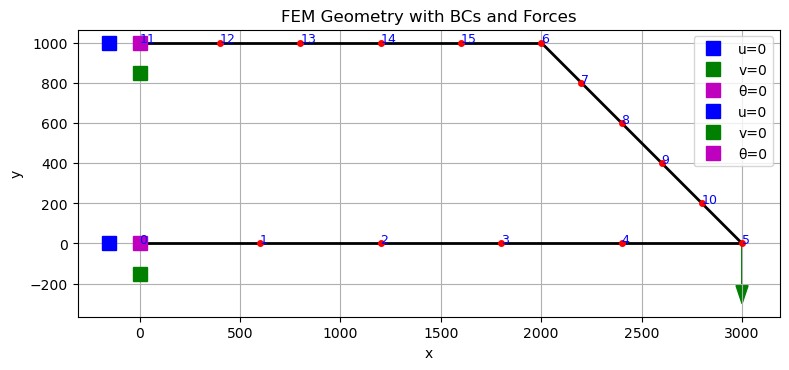

In [128]:
plot_fem_model(
    node_coords=fem_nodes,
    fem_elements=fem_elements,
    bc_nodes=bc_nodes,
    bc_dofs=bc_dofs,
    bc_vals=bc_values,
    force_nodes=f_nodes,
    force_dofs=f_dofs,
    force_vals=f_values,
    scale_force=0.3
)


### Assembling the external force vector

In [108]:
def build_force_vector(f_nodes, f_dofs, f_values, num_dofs, dofs_per_node):
    """
    Assembles the global external force vector for the structure.

    Args:
        f_nodes: List of node indices where forces are applied.
        f_dofs: List of DOF indices (0: u, 1: v, 2: θ) at each node where force is applied.
        f_values: List of force or moment values to apply.
        num_dofs: Total number of degrees of freedom.
        dofs_per_node: Number of degrees of freedom per node (e.g. 1 for rod, 2 for beam, 3 for 2D frame).

    Returns:
        f_ext: Global force vector (1D numpy array).
    """
    f_ext = np.zeros(num_dofs)

    for node, dof, value in zip(f_nodes, f_dofs, f_values):
        global_dof = node * dofs_per_node + dof
        f_ext[global_dof] += value  # add in case multiple forces on same DOF

    return f_ext


In [109]:
num_dofs = K_frame.shape[0]  # total DOFs for a 2D frame
dofs_per_node = 3   # 2d beam element

f_ext = build_force_vector(f_nodes=f_nodes,
                           f_dofs=f_dofs,
                           f_values=f_values,
                           num_dofs=num_dofs,
                           dofs_per_node=dofs_per_node)

# check
display(sy.Matrix(f_ext), f_ext.shape)


Matrix([
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[-1000.0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0],
[      0]])

(48,)

### Static analysis

In [110]:
def static_analysis(K_global, f_ext, bc_nodes, bc_dofs, bc_values):
    """
    Solves the static system K * u = f_ext for the displacement vector u, after applying boundary conditions (BCs).

    Args:
        K_global: The global stiffness matrix.
        f_ext: The external force vector.
        bc_nodes: The nodes where boundary conditions are applied.
        bc_dofs: The DOFs (0=horizontal, 1=vertical, 2=rotation) that are prescribed.
        bc_values: The values of the prescribed boundary conditions.

    Returns:
        u: The displacement vector, containing displacements for all DOFs.
    """
    
    # 1. Create the displacement vector 'u' initialized to zeros
    num_dofs = K_global.shape[0]
    u = np.zeros(num_dofs)
    
    # 2. Apply boundary conditions (set the prescribed displacements in 'u')
    constrained_dof_ids = [node * 3 + dof for node, dof in zip(bc_nodes, bc_dofs)]
    
    # Apply BC values to the displacement vector
    for dof_id, value in zip(constrained_dof_ids, bc_values):
        u[dof_id] = value
    
    # 3. Apply boundary conditions to K_global and f_ext by modifying them
    # We will create a reduced system, eliminating the constrained DOFs
    K_reduced = np.delete(K_global, constrained_dof_ids, axis=0)
    K_reduced = np.delete(K_reduced, constrained_dof_ids, axis=1)
    
    f_ext_reduced = np.delete(f_ext, constrained_dof_ids)
    
    # 4. Solve the reduced system for the unknown displacements
    u_reduced = np.linalg.solve(K_reduced, f_ext_reduced)
    
    # 5. Insert the solved displacements back into the global displacement vector 'u'
    free_dof_ids = list(set(range(num_dofs)) - set(constrained_dof_ids))
    u[free_dof_ids] = u_reduced
    
    return u


In [111]:
u = static_analysis(K_frame, f_ext, bc_nodes, bc_dofs, bc_values)

### Stress computation

In [112]:
def eval_stress(u, fem_elements, fem_nodes, element_sections, material, section_shape, k_local_func, R_func, ndof_per_node):
    """
    Computes axial + bending stress in each frame element.

    Args:
        u: Global displacement vector.
        fem_elements: (n_elements, 2) connectivity matrix.
        fem_nodes: (n_nodes, 2) node coordinates.
        element_sections: (n_elements, 2) array of [A, I] for each element.
        section_shape: str - "rectangle" or "circular"
        material: {"E" = E, "rho" = rho}
        k_local_func: function returning 6x6 stiffness matrix in local system (so theoretically you could use a different function than k_beam2d)
        R_func: function returning rotation matrix.

    Returns:
        stress_max: max absolute stress (tension or compression) per element
        stress_axial: N / A
        stress_bending: M * c / I
        stress_shear: estimated max shear stress (section dependent)
        vonMises_stress
    """
    E = material["E"]
    stress_max = []
    stress_axial = []
    stress_bending = []
    stress_shear = []
    von_mises_stress = []
    Nvec = []
    Vvec = []
    Mvec = []

    for e, (n1, n2) in enumerate(fem_elements):
        
        # get node coordinates for each element
        x1, y1 = fem_nodes[n1]
        x2, y2 = fem_nodes[n2]

        # get geometry params for each element
        A, I = element_sections[e]['A'], element_sections[e]['I']
        L = np.hypot(x2 - x1, y2 - y1)

        # get height based on the cross section shape
        match section_shape:
            case "rectangle":
                h = np.sqrt(12 * I / A)
                c = h / 2
                coeff = 3/2
            case "circular":
                c = np.sqrt(A / np.pi)
                coeff = 4/3
            case _ :
                return "Section shape not supported. Only possibilities are 'rectangle' and 'circular'"

        # DOF mapping
        #dof_map = get_dof_map(ndof_per_node, n1, n2)
        dof_map = [n1 * 3 + i for i in range(3)] + [n2 * 3 + i for i in range(3)]
        # displacement of the 2 nodes of the element in the global system
        u_e_global = u[dof_map]

        # rotate to local coordinates
        R = R_func(x1, y1, x2, y2)
        u_e_local = R @ u_e_global

        # local stiffness
        k_local = k_local_func(E, A, I, L)
        f_local = k_local @ u_e_local

        # axial force
        # compute axial strain from local displacements
        delta_L = u_e_local[3] - u_e_local[0]  # u2_local - u1_local (in axial dir)
        strain = delta_L / L
        N = E * A * strain

        # debug
        #display(f"u_e_global element {e}, with points {(x1, y1), (x2, y2)} and DELTA(L) {delta_L}:", sy.Matrix(u_e_global))
        #display(f"u_e_local element {e} :", sy.Matrix(u_e_local))
        # f_local contains: f1 = axial force at node 1
        #                   f2 = shear force at node 1
        #                   f3 = moment at node 1
        #                   f4...f6 = similar but for node 2

        # The rod (bar) element is a constant strain (so constant stress) element. For the beam element instead, a point must be chosen where to compute the stress values. I arbitrarily chose point 1 (even if better choice would be on Gauss points, maybe to implement later)
        
        # computing stress at one point (node 1), the result is approximate. In reality, stress varies linearly (depends on the loading condition and what stress we are talking about (moment with distributed load goes quadratically)) along the element. Better approach, consider evaluating at Gauss points or at multiple points and returning max values.
        
        # shear force
        V = f_local[1]

        # bending moment 
        M = f_local[2]

        # Stress components
        sigma_axial = N / A
        sigma_bend = -M * c / I

        tau_xy = coeff * V / A

        # Total max tension/compression stress (superposition)
        sigma_top = sigma_axial + sigma_bend 
        sigma_bottom = sigma_axial - sigma_bend 

        # take the max, preserving the sign
        sigma_max = sigma_top if abs(sigma_top) >= abs(sigma_bottom) else sigma_bottom

        # vonMises stress
        sigma_von_mises = np.sqrt(sigma_max**2 + 3*tau_xy**2)

        stress_max.append(sigma_max)
        stress_axial.append(sigma_axial)
        stress_bending.append(sigma_bend)
        stress_shear.append(tau_xy)
        von_mises_stress.append(sigma_von_mises)
        Nvec.append(N)
        Vvec.append(V)
        Mvec.append(M)
    
    internal_actions = np.column_stack((Nvec, Vvec, Mvec))

    return (
        np.array(stress_max), 
        np.array(stress_axial), 
        np.array(stress_bending),
        np.array(stress_shear),
        np.array(von_mises_stress),
        internal_actions
    )


In [113]:
stress_max, stress_axial, stress_bending, stress_shear, von_mises_stress, internal_actions = eval_stress(u, fem_elements, fem_nodes, element_crossSections, mat_properties, "rectangle", k_beam2d, rotation_2d, ndof_per_node=3)

display(sy.Matrix(internal_actions))


Matrix([
[-1747.24566633703,  276.002158027736,  428260.639863068],
[-1747.24566633703,  276.002158027731,  262659.345046426],
[-1747.24566633703,  276.002158027739,  97058.0502297869],
[-1747.24566633703,  276.002158027506, -68543.2445868552],
[-1747.24566633703,  276.002158027542,  -234144.53940336],
[ 1747.43304267994, -723.545475443127, -623501.990145177],
[ 1747.43304269361, -723.545475444116, -418852.425272107],
[ 1747.43304269361, -723.545475443418, -214202.860398762],
[  1747.4330426919, -723.545475441613,  -9553.2955256179],
[ 1747.43304268678, -723.545475442341,  195096.269347027],
[ 1747.24566633145,  723.997841970823,  824493.693796429],
[ 1747.24566633145,  723.997841970788,    534894.5570081],
[ 1747.24566633145,   723.99784197082,  245295.420219785],
[ 1747.24566633145,  723.997841970791, -44303.7165685445],
[ 1747.24566634142,   723.99784197082, -333902.853356853]])

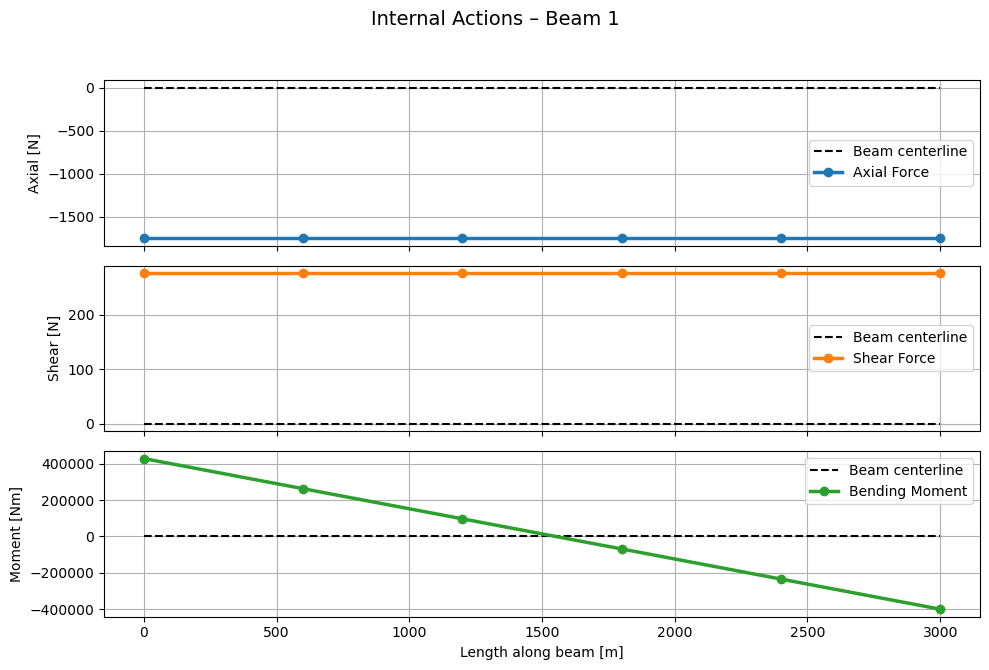

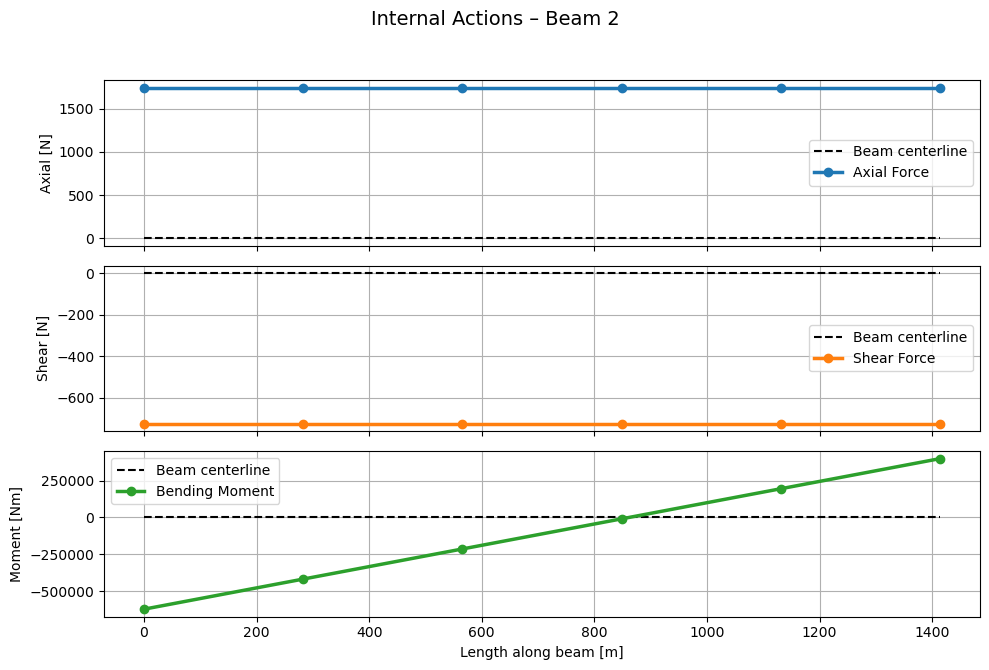

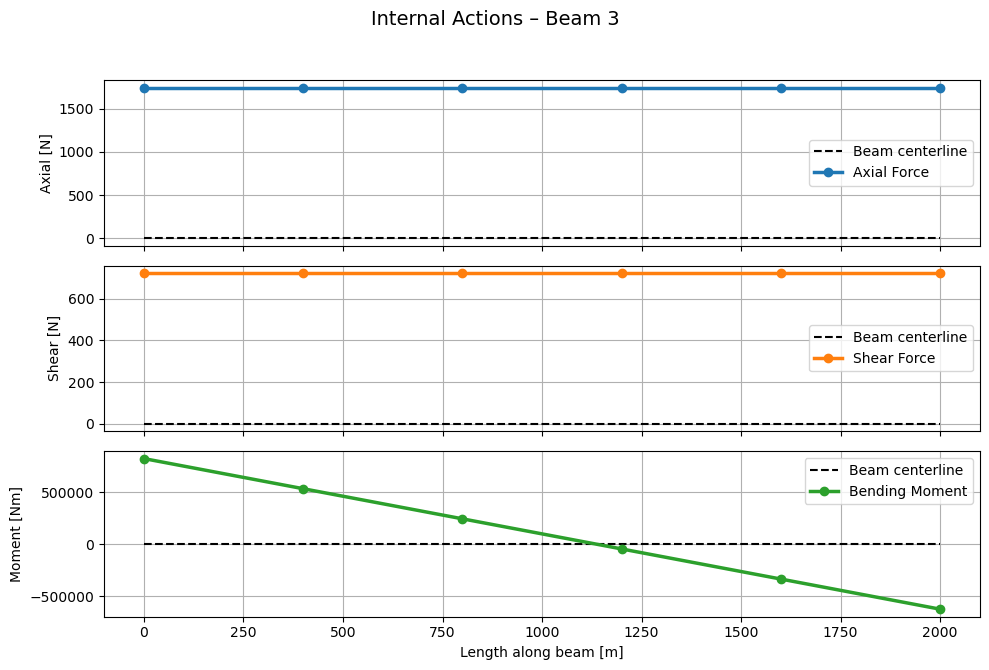

In [114]:
def plot_internal_actions(
    beam_connectivity,
    fem_nodes,
    fem_elements,
    internal_actions,
    elements_per_beam=5
):
    """
    Plot internal action diagrams (Axial, Shear, Moment) per beam.
    
    Each beam is shown with:
    - Black dashed line as the physical beam
    - Internal force/moment diagram plotted on top

    Parameters:
        node_coords_beam: (n_beam_nodes, 2) array of node coordinates (coarse geometry).
        beam_connectivity: (n_beams, 2) array of beam connectivity (coarse definition).
        fem_nodes: (n_fem_nodes, 2) array of FEM node coordinates.
        fem_elements: (n_elements, 2) array of FEM element connectivity.
        internal_actions: (n_elements, 3) array of [N, V, M] values per element.
        elements_per_beam: number of FEM elements per beam (default = 5).
    """
    num_beams = beam_connectivity.shape[0]

    for beam_id in range(num_beams):
        el_start = beam_id * elements_per_beam
        el_end = el_start + elements_per_beam
        beam_elements = fem_elements[el_start:el_end]
        beam_actions = internal_actions[el_start:el_end]  # shape: (elements_per_beam, 3)

        arc_lengths = []
        N_vals, V_vals, M_vals = [], [], []

        base_node = fem_nodes[beam_elements[0][0]]

        for i in range(elements_per_beam):
            n1_idx = beam_elements[i][0]
            pt = fem_nodes[n1_idx]
            arc_len = np.linalg.norm(pt - base_node)

            arc_lengths.append(arc_len)
            N_vals.append(beam_actions[i][0])
            V_vals.append(beam_actions[i][1])
            M_vals.append(beam_actions[i][2])

        # Add last node position and extrapolate values
        pt_last = fem_nodes[beam_elements[-1][1]]
        arc_last = np.linalg.norm(pt_last - base_node)
        arc_lengths.append(arc_last)

        def extrapolate(values):
            return values[-1] + (values[-1] - values[-2])

        N_vals.append(extrapolate(N_vals))
        V_vals.append(extrapolate(V_vals))
        M_vals.append(extrapolate(M_vals))

        # Plotting
        fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
        fig.suptitle(f'Internal Actions – Beam {beam_id + 1}', fontsize=14)

        margin = 0.05 * (arc_lengths[-1] - arc_lengths[0])
        xlim = [arc_lengths[0] - margin, arc_lengths[-1] + margin]

        # Beam baseline for reference
        for ax in axs:
            ax.plot([arc_lengths[0], arc_lengths[-1]], [0, 0], 'k--', linewidth=1.5, label='Beam centerline')
            ax.set_xlim(xlim)
            ax.legend(loc="upper right")
            ax.grid(True)

        axs[0].plot(arc_lengths, N_vals, '-o', color='tab:blue', linewidth=2.5, label='Axial Force')
        axs[0].set_ylabel('Axial [N]')
        axs[0].legend()

        axs[1].plot(arc_lengths, V_vals, '-o', color='tab:orange', linewidth=2.5, label='Shear Force')
        axs[1].set_ylabel('Shear [N]')
        axs[1].legend()

        axs[2].plot(arc_lengths, M_vals, '-o', color='tab:green', linewidth=2.5, label='Bending Moment')
        axs[2].set_ylabel('Moment [Nm]')
        axs[2].set_xlabel('Length along beam [m]')
        axs[2].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_internal_actions(
    beam_connectivity=beam_connectivity,
    fem_nodes=fem_nodes,
    fem_elements=fem_elements,
    internal_actions=internal_actions,
    elements_per_beam=5
)


### Reaction components

In [115]:
def compute_reaction_forces(K_global, U, bc_nodes, bc_dofs):
    """
    Compute the reaction forces at constrained DOFs in a 2D frame.

    Parameters:
        K_global: Full global stiffness matrix (N_dof x N_dof)
        U: Full global displacement vector (including constrained DOFs)
        bc_nodes: List of nodes with prescribed BCs
        bc_dofs:  List of DOFs per node (e.g. 0 for ux, 1 for uy, 2 for theta)

    Returns:
        reactions: Array of reaction forces at prescribed DOFs
        constrained_dof_ids: List of constrained DOF indices used
    """
    # Map (node, dof) to global DOF indices
    constrained_dof_ids = [node * 3 + dof for node, dof in zip(bc_nodes, bc_dofs)]

    # Compute internal force vector from stiffness * displacement
    F_internal = K_global @ U

    # Reactions are internal forces at constrained DOFs
    reactions = F_internal[constrained_dof_ids]

    for dof, r in zip(constrained_dof_ids, reactions):
        print(f"DOF {dof}: Reaction force = {r:.2f} N")

    return reactions, constrained_dof_ids


In [116]:
reactions, constrained_dofs = compute_reaction_forces(K_frame, u, bc_nodes, bc_dofs)

# Display results
#for dof, r in zip(constrained_dofs, reactions):
#    print(f"DOF {dof}: Reaction force = {r:.2f} N")

DOF 0: Reaction force = 1747.25 N
DOF 1: Reaction force = 276.00 N
DOF 2: Reaction force = 428260.64 N
DOF 33: Reaction force = -1747.25 N
DOF 34: Reaction force = 724.00 N
DOF 35: Reaction force = 824493.69 N


### Plotting deformation and von Mises stresses

In [117]:
from matplotlib.collections import LineCollection
from matplotlib import colormaps

def plot_loaded_structure(
    fem_nodes, fem_elements, u, stress_values, stress_type, scale=1.0, title=None, show_labels=False
):
    """
    Plots the undeformed and deformed structure with von Mises stress color map.

    Parameters:
        fem_nodes: (N, 2) array of node coordinates
        fem_elements: (E, 2) array of element connectivity
        u: global displacement vector (3 DOFs per node)
        stress_values: (E,) array of stress values per element
        stress_type: str, one of 'von Mises', 'axial', 'bending', 'shear
        scale: float, deformation magnification factor
        title: plot title
        show_labels: if True, adds stress value labels at element midpoints
    """
    num_nodes = fem_nodes.shape[0]
    u_nodes = np.zeros_like(fem_nodes)

    # Extract displacements (ux, uy)
    for i in range(num_nodes):
        u_nodes[i, 0] = u[i * 3]
        u_nodes[i, 1] = u[i * 3 + 1]

    # Apply scaling
    deformed_nodes = fem_nodes + scale * u_nodes

    # Prepare segments and colors
    lines_undeformed = []
    lines_deformed = []
    stress_colors = []

    for e, (n1, n2) in enumerate(fem_elements):
        p1, p2 = fem_nodes[n1], fem_nodes[n2]
        q1, q2 = deformed_nodes[n1], deformed_nodes[n2]

        lines_undeformed.append([p1, p2])
        lines_deformed.append([q1, q2])
        #stress_colors.append(von_mises_stress[e])
        stress_colors.append(stress_values[e])

    # Convert stress values to colormap
    stress_colors = np.array(stress_colors)
    cmap = colormaps['viridis']
    color_norm = (stress_colors - stress_colors.min()) / (stress_colors.max() - stress_colors.min() + 1e-9)
    color_mapped = cmap(color_norm)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_aspect('equal')

    # Undeformed (gray)
    undeformed = LineCollection(lines_undeformed, colors='lightgray', linewidths=2, label='Undeformed')
    ax.add_collection(undeformed)

    # Deformed with stress color
    deformed = LineCollection(lines_deformed, colors=color_mapped, linewidths=3, label='Deformed')
    ax.add_collection(deformed)

    # Optional stress labels at element midpoints
    if show_labels:
        for e, (n1, n2) in enumerate(fem_elements):
            midpoint = (deformed_nodes[n1] + deformed_nodes[n2]) / 2
            ax.text(
                midpoint[0], midpoint[1],
                f"{stress_colors[e]:.1f}",
                color='black', fontsize=8, ha='center', va='center',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2')
            )

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(stress_colors)
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(f"{stress_type.capitalize()} Stress [MPa]")
    #cbar.set_label("Von Mises Stress [MPa]")

    # Labels and axes
    if title is None:
        title = f"Deformation and {stress_type.capitalize()} Stress"
    ax.set_title(title)
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    ax.grid(True)
    ax.legend()

    # Set axis limits
    all_points = np.vstack((fem_nodes, deformed_nodes))
    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
    pad_x = 0.1 * (x_max - x_min) if x_max != x_min else 1.0
    pad_y = 0.1 * (y_max - y_min) if y_max != y_min else 1.0
    ax.set_xlim(x_min - pad_x, x_max + pad_x)
    ax.set_ylim(y_min - pad_y, y_max + pad_y)

    plt.tight_layout()
    plt.show()


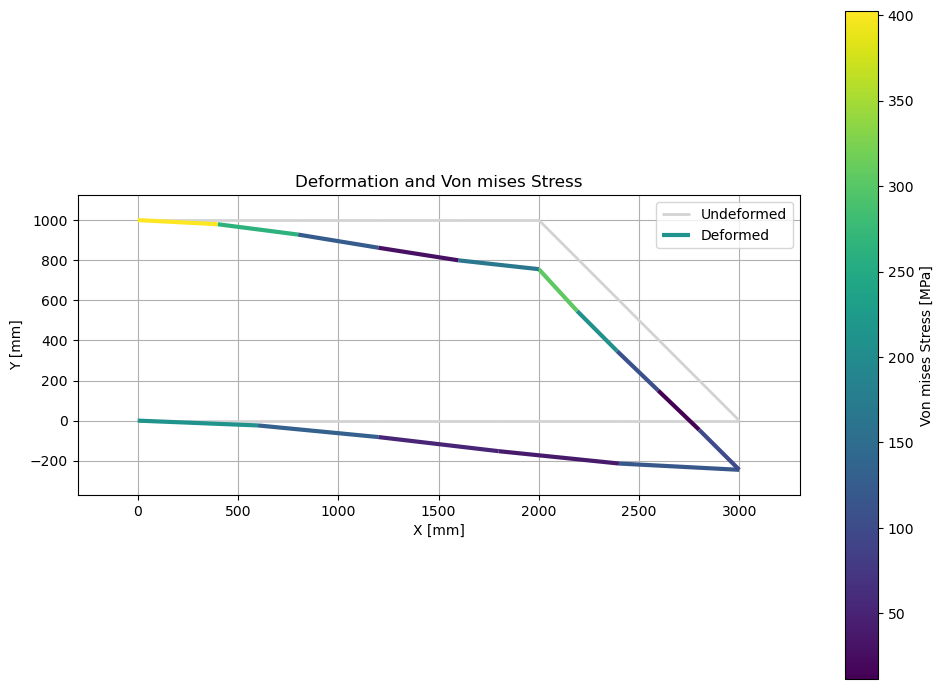

In [129]:
# change scale as you wish
plot_loaded_structure (fem_nodes, fem_elements, u, von_mises_stress, stress_type="von Mises", scale=3, show_labels=False)

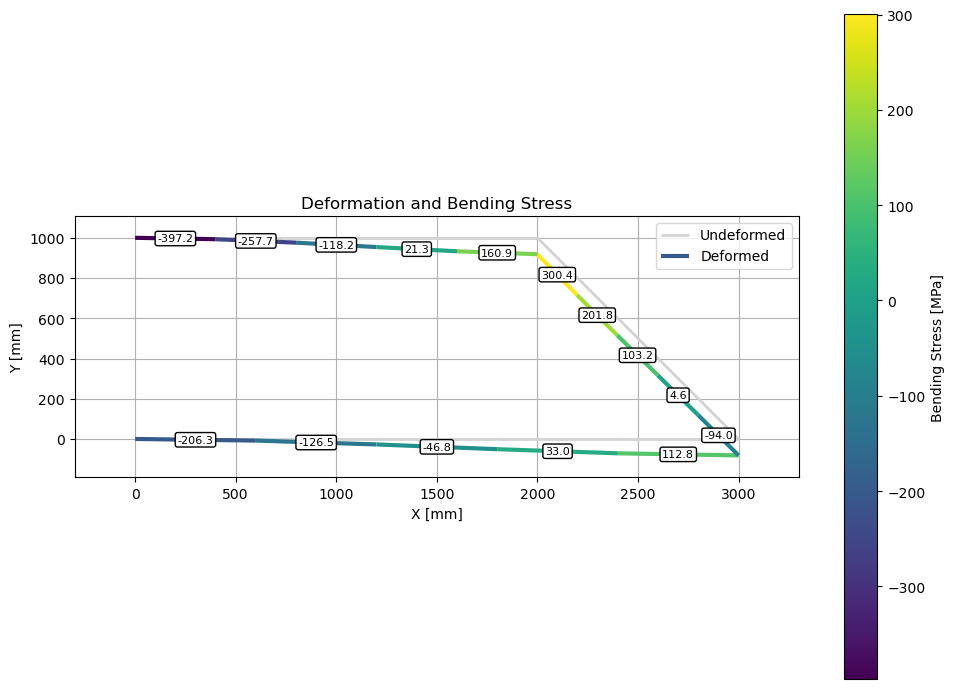

In [119]:
plot_loaded_structure (fem_nodes, fem_elements, u, stress_bending, stress_type="bending", scale=1, show_labels=True)

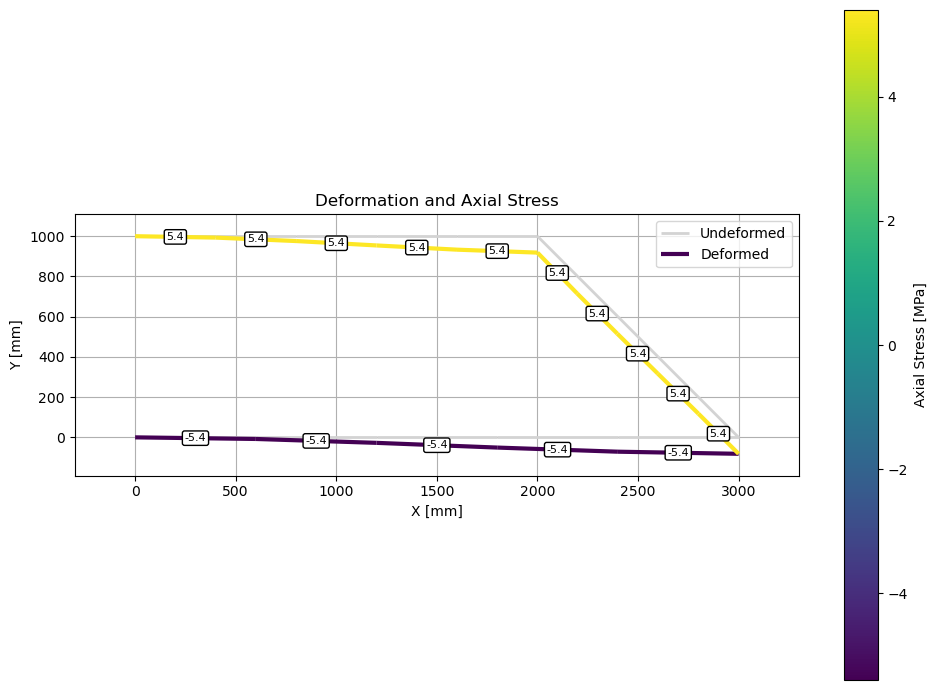

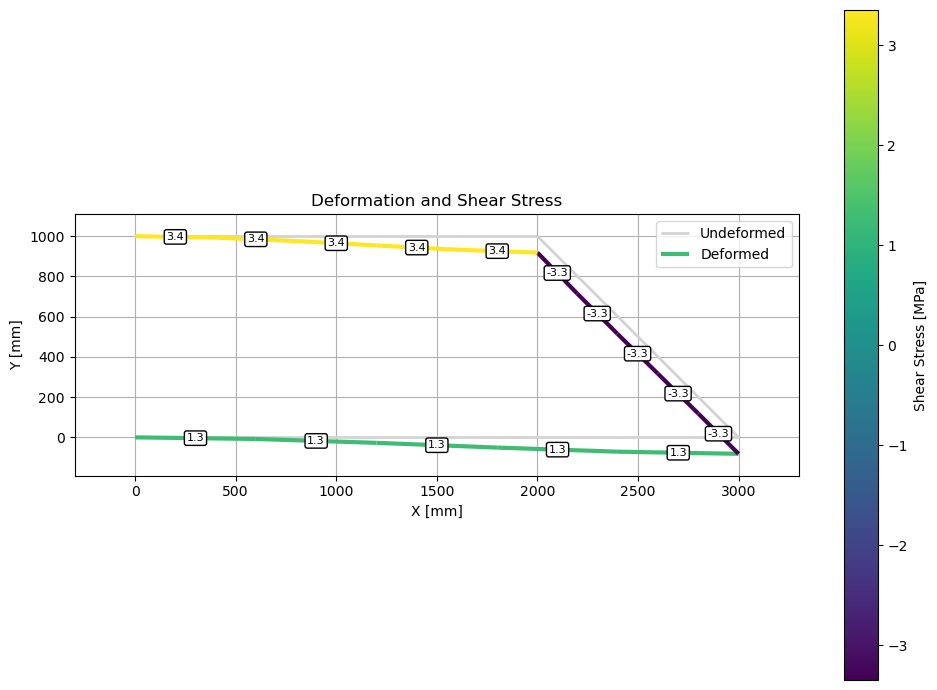

In [120]:
plot_loaded_structure (fem_nodes, fem_elements, u, stress_axial, stress_type="axial", scale=1, show_labels=True)

plot_loaded_structure (fem_nodes, fem_elements, u, stress_shear, stress_type="shear", scale=1, show_labels=True)


### Modal analysis

In [121]:
from scipy.linalg import eigh  # Symmetric eigenvalue solver

def modal_analysis(K_global, M_global, bc_nodes, bc_dofs, num_modes=5):
    """
    Solves the eigenvalue problem for natural frequencies of a 2D frame.

    Parameters:
        K_global : Global stiffness matrix
        M_global : Global mass matrix
        bc_nodes : List of constrained nodes
        bc_dofs : List of constrained dofs (0: u_x, 1: u_y, 2: theta)
        num_modes : Number of natural frequencies to compute

    Returns:
        frequencies_hz : Natural frequencies in Hz (array of length num_modes)
        mode_shapes : Mode shapes (each column is a mode)
    """
    total_dofs = K_global.shape[0]
    all_dofs = np.arange(total_dofs)

    # Build constrained DOFs list
    constrained_dofs = [node * 3 + dof for node, dof in zip(bc_nodes, bc_dofs)]
    constrained_dofs = sorted(set(constrained_dofs))

    # Free DOFs
    free_dofs = np.setdiff1d(all_dofs, constrained_dofs)

    # Reduce K and M
    K_ff = K_global[np.ix_(free_dofs, free_dofs)]
    M_ff = M_global[np.ix_(free_dofs, free_dofs)]

    # Solve the generalized eigenvalue problem
    eigvals, eigvecs = eigh(K_ff, M_ff)

    # Remove negative or zero eigenvalues (numerical issues)
    positive = eigvals > 1e-8
    eigvals = eigvals[positive]
    eigvecs = eigvecs[:, positive]

    # Limit to num_modes
    eigvals = eigvals[:num_modes]
    eigvecs = eigvecs[:, :num_modes]

    # Convert to frequencies in Hz
    omegas = np.sqrt(eigvals)
    frequencies_hz = omegas / (2 * np.pi)


    for i, f in enumerate(frequencies_hz):
        print(f"Mode {i+1}: {f:.2f} Hz")

    return frequencies_hz, eigvecs, free_dofs


In [122]:
frequencies, mode_shapes, free_dofs = modal_analysis(
    K_frame, M_frame,
    bc_nodes, bc_dofs,
)

Mode 1: 0.19 Hz
Mode 2: 0.69 Hz
Mode 3: 1.28 Hz
Mode 4: 1.92 Hz
Mode 5: 2.62 Hz


### Animated plot for mode shapes visualization

In [123]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_mode_shape_2d(mode_index, eigenvecs, node_coords, free_dofs, K, elements, ndof_per_node, amplification=100, save_as=None):
    """
    Animate a mode shape for a 2D frame (with 3 DOFs per node).

    Parameters:
        mode_index: Index of the mode (0-based)
        eigenvecs: Array of eigenvectors from reduced system
        node_coords: (N, 2) array of node positions
        free_dofs: List of free DOF indices
        K: Global stiffness matrix (to get total DOFs)
        elements: (E, 2) array with node indices for each element
        amplification: Visual scaling factor for displacements
        save_as: Optional filename to save animation (e.g., "mode1.gif")
    
    Returns:
        HTML animation (for Jupyter notebooks)
    """
    num_nodes = node_coords.shape[0]
    total_dofs = K.shape[0]

    # Reconstruct full mode shape including constrained DOFs
    full_mode = np.zeros(total_dofs)
    full_mode[free_dofs] = eigenvecs[:, mode_index]

    # Split displacements into per-node ux and uy
    u_disp = full_mode[0::ndof_per_node]  # ux
    v_disp = full_mode[1::ndof_per_node]  # uy
    #theta  = full_mode[2::3]  # unused in plot, could rotate if desired

    # Normalize mode shape
    max_disp = np.max(np.sqrt(u_disp**2 + v_disp**2))
    u_disp /= max_disp
    v_disp /= max_disp

    u_disp *= amplification
    v_disp *= amplification

    # Undeformed shape
    x_static = node_coords[:, 0]
    y_static = node_coords[:, 1]

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_title(f"Mode Shape {mode_index + 1}")
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    ax.grid(True)

    # Plot undeformed structure
    for el in elements:
        x = [node_coords[el[0], 0], node_coords[el[1], 0]]
        y = [node_coords[el[0], 1], node_coords[el[1], 1]]
        ax.plot(x, y, 'k--', linewidth=1, alpha=0.3)

    line_collection = []
    for _ in elements:
        line, = ax.plot([], [], 'b-', lw=2)
        line_collection.append(line)

    margin = amplification * 1.5
    ax.set_xlim(x_static.min() - margin, x_static.max() + margin)
    ax.set_ylim(y_static.min() - margin, y_static.max() + margin)

    # Animation update
    def update(frame):
        factor = np.sin(2 * np.pi * frame / 60)
        displaced_coords = node_coords + factor * np.column_stack((u_disp, v_disp))

        for i, el in enumerate(elements):
            x = [displaced_coords[el[0], 0], displaced_coords[el[1], 0]]
            y = [displaced_coords[el[0], 1], displaced_coords[el[1], 1]]
            line_collection[i].set_data(x, y)

        return line_collection

    ani = FuncAnimation(fig, update, frames=60, interval=50, blit=True)

    if save_as:
        ani.save(save_as, writer="pillow")
        print(f"Animation saved as {save_as}")
        plt.close(fig)
    else:
        plt.close(fig)
        return HTML(ani.to_jshtml())


In [124]:
animate_mode_shape_2d(
    mode_index=0,
    eigenvecs=mode_shapes,
    node_coords=fem_nodes,
    free_dofs=free_dofs,
    K=K_frame,
    elements=fem_elements,
    ndof_per_node=3,
    amplification=200
)


In [125]:
animate_mode_shape_2d(
    mode_index=1,
    eigenvecs=mode_shapes,
    node_coords=fem_nodes,
    free_dofs=free_dofs,
    K=K_frame,
    elements=fem_elements,
    ndof_per_node=3,
    amplification=200
)

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import sys

def animate_mode_shape_2d_script(
    mode_index, eigenvecs, node_coords, free_dofs, K, elements, ndof_per_node,
    amplification=100, save_as=None, show=True
):
    """
    Animate a mode shape for a 2D frame (with 3 DOFs per node).

    Parameters:
        mode_index: Index of the mode (0-based)
        eigenvecs: Array of eigenvectors from reduced system
        node_coords: (N, 2) array of node positions
        free_dofs: List of free DOF indices
        K: Global stiffness matrix (to get total DOFs)
        elements: (E, 2) array with node indices for each element
        amplification: Visual scaling factor for displacements
        save_as: Optional filename to save animation (e.g., "mode1.gif")
        show: Whether to display the animation (set False for silent save)

    Returns:
        None
    """
    total_dofs = K.shape[0]
    full_mode = np.zeros(total_dofs)
    full_mode[free_dofs] = eigenvecs[:, mode_index]

    u_disp = full_mode[0::ndof_per_node]  # ux
    v_disp = full_mode[1::ndof_per_node]  # uy

    max_disp = np.max(np.sqrt(u_disp**2 + v_disp**2))
    if max_disp < 1e-12:
        max_disp = 1e-12  # prevent division by zero

    u_disp /= max_disp
    v_disp /= max_disp
    u_disp *= amplification
    v_disp *= amplification

    # Setup plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    ax.set_title(f"Mode Shape {mode_index + 1}")
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    ax.grid(True)

    # Plot undeformed structure
    for el in elements:
        x = [node_coords[el[0], 0], node_coords[el[1], 0]]
        y = [node_coords[el[0], 1], node_coords[el[1], 1]]
        ax.plot(x, y, 'k--', linewidth=1, alpha=0.3)

    line_collection = []
    for _ in elements:
        line, = ax.plot([], [], 'b-', lw=2)
        line_collection.append(line)

    margin = amplification * 1.5
    ax.set_xlim(node_coords[:, 0].min() - margin, node_coords[:, 0].max() + margin)
    ax.set_ylim(node_coords[:, 1].min() - margin, node_coords[:, 1].max() + margin)

    def update(frame):
        factor = np.sin(2 * np.pi * frame / 60)
        displaced_coords = node_coords + factor * np.column_stack((u_disp, v_disp))

        for i, el in enumerate(elements):
            x = [displaced_coords[el[0], 0], displaced_coords[el[1], 0]]
            y = [displaced_coords[el[0], 1], displaced_coords[el[1], 1]]
            line_collection[i].set_data(x, y)

        return line_collection

    ani = FuncAnimation(fig, update, frames=60, interval=50, blit=True)

    if save_as:
        ani.save(save_as, writer="pillow")
        print(f"Animation saved to {save_as}")
        plt.close(fig)
    elif show:
        plt.show()
    else:
        plt.close(fig)


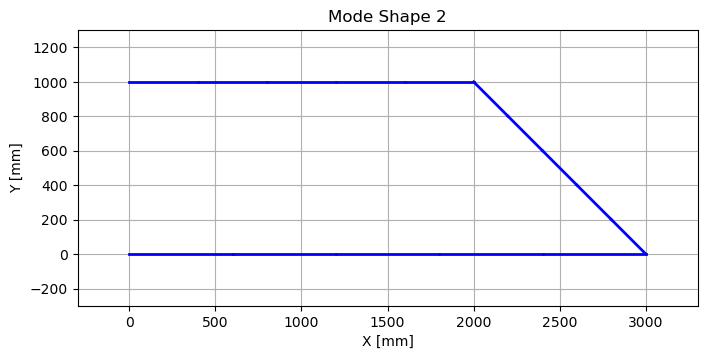

In [127]:
animate_mode_shape_2d_script(
    mode_index=1,
    eigenvecs=mode_shapes,
    node_coords=fem_nodes,
    free_dofs=free_dofs,
    K=K_frame,
    ndof_per_node=3,
    elements=fem_elements,
    amplification=200
)